In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import ligo.skymap.plot

/home/ethan.marx/projects/mdc-analytics/.venv/lib/python3.10/site-packages/ligo/lw/lsctables.py:89: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [4]:
events = pd.read_hdf("/home/ethan.marx/projects/mdc_analytics/output/cycle7/events.hdf5")

In [45]:
dq_mask = events["H1:DMT-ANALYSIS_READY:1"] & events["L1:DMT-ANALYSIS_READY:1"]
parameter_space_mask = events["chirp_mass"] > 10 
parameter_space_mask &= events["chirp_mass"] < 100
parameter_space_mask &= events["snr_net"] > 8

found_mask = events["aframe_graceid"].values != None
found = events[dq_mask & found_mask & parameter_space_mask]
missed = events[dq_mask & ~found_mask & parameter_space_mask]

print(f"Found {len(found)} events in parameter space")
print(f"Missed {len(missed)} events in parameter space")

found_outside = events[dq_mask & found_mask & ~parameter_space_mask]
missed_outside = events[dq_mask & ~found_mask & ~parameter_space_mask]

print(f"Found {len(found_outside)} events outside parameter space")
print(f"Missed {len(missed_outside)} events outside parameter space")

Found 87 events in parameter space
Missed 69 events in parameter space
Found 77 events outside parameter space
Missed 1408 events outside parameter space


In [ ]:
found_outside.chirp_mass

67      272.697883
89        7.991331
111      47.978996
125       5.726698
126       6.590981
           ...    
1958      9.861011
1963     61.494482
1964     45.972692
1976    109.868424
1995     97.854133
Name: chirp_mass, Length: 77, dtype: float64

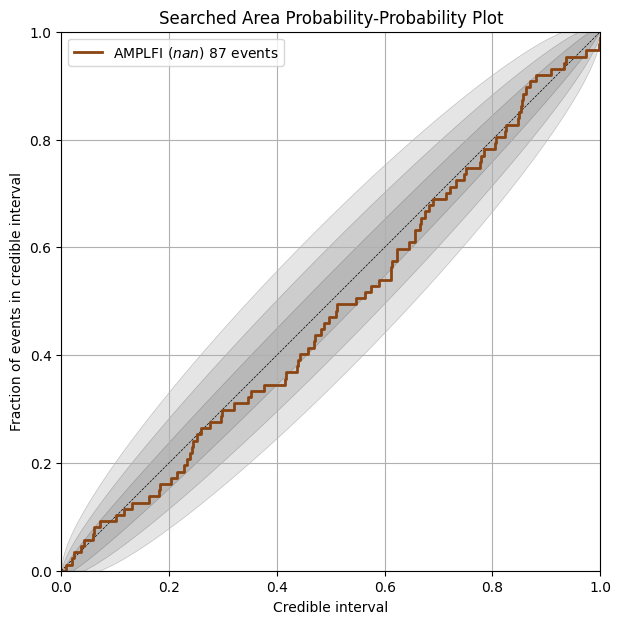

In [10]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection="pp_plot")

number_of_samples = len(found)
alphas = [0.68, 0.95, 0.997]
for alpha in alphas:
    ax.add_confidence_band(
        number_of_samples,
        alpha=alpha,
        color=(0, 0, 0, 0.1),
        edgecolor=(0, 0, 0, 0.2),
        annotate=False,
    )
ax.add_diagonal()
p = scipy.stats.kstest(found['aframe_searched_prob'], "uniform").pvalue
ax.add_series(
    found["aframe_searched_prob"],
    label="AMPLFI"
    + r"$~({0:#.2g})$ ".format(round(p, 2))
    + str(len(found))
    + " events",
    color="saddlebrown",
    linewidth=2,
)
"""
p = scipy.stats.kstest(filtered['gstlal_searched_prob'], "uniform").pvalue
ax.add_series(
    filtered["gstlal_searched_prob"],
    label="Gstlal"
    + r"$~({0:#.2g})$ ".format(round(p, 2))
    + str(len(filtered))
    + " events",
    color="blue",
    linewidth=2,
)
"""
plt.title("Searched Area Probability-Probability Plot")
ax.set_xlabel("Credible interval")
ax.set_ylabel("Fraction of events in credible interval")
ax.grid(True)
ax.legend()

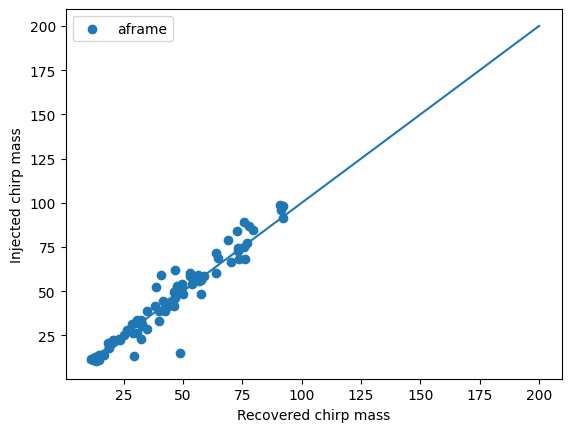

In [60]:
plt.scatter(found["aframe_chirp_mass"], found["chirp_mass"], label="aframe")
#plt.scatter(filtered["gstlal_chirp_mass"], filtered["chirp_mass"], label="gstlal")
plt.xlabel("Recovered chirp mass")
plt.ylabel("Injected chirp mass")
plt.plot([10, 200], [10, 200])
plt.legend()

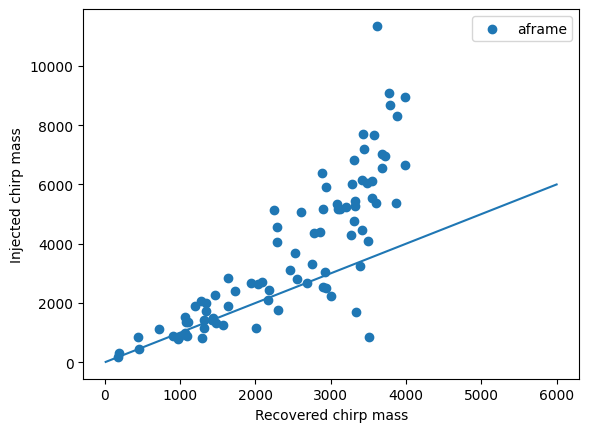

In [59]:
plt.scatter(found["aframe_luminosity_distance"], found["luminosity_distance"], label="aframe")
#plt.scatter(filtered["gstlal_chirp_mass"], filtered["chirp_mass"], label="gstlal")
plt.xlabel("Recovered chirp mass")
plt.ylabel("Injected chirp mass")
plt.plot([10, 6000], [10, 6000])
plt.legend()

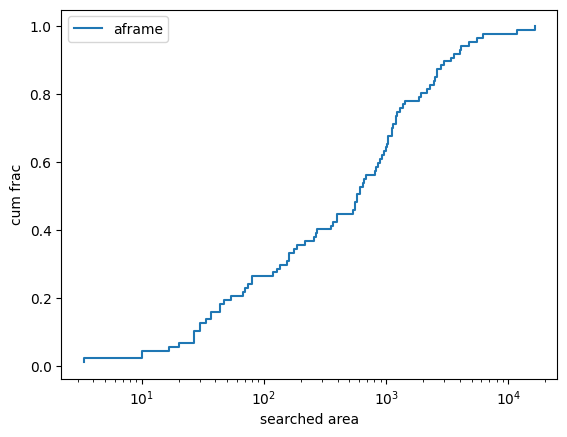

In [58]:
counts = np.arange(1, len(found) + 1) / len(found)
plt.step(np.sort(found["aframe_searched_area"]), counts, label="aframe")
#plt.step(np.sort(filtered["gstlal_searched_area"]), counts, label="gstlal")
plt.xlabel("searched area")
plt.ylabel("cum frac")
plt.legend()
plt.xscale("log")

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,
          1.,   1.,   1.,   1.,   1.,   0.,   2.,   3., 362.]),
 array([0.00726454, 0.05690131, 0.10653809, 0.15617486, 0.20581163,
        0.25544841, 0.30508518, 0.35472195, 0.40435872, 0.4539955 ,
        0.50363227, 0.55326904, 0.60290582, 0.65254259, 0.70217936,
        0.75181614, 0.80145291, 0.85108968, 0.90072645, 0.95036323,
        1.        ]),
 <BarContainer object of 20 artists>)

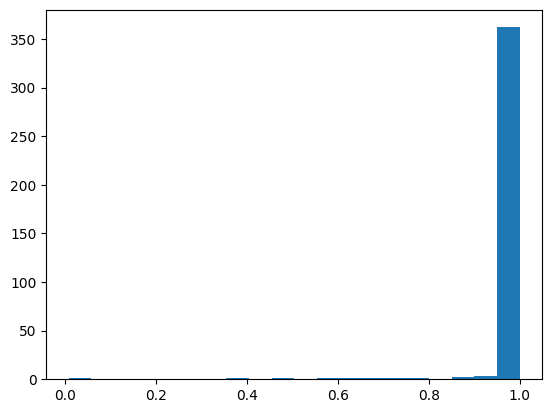

In [ ]:
found = 

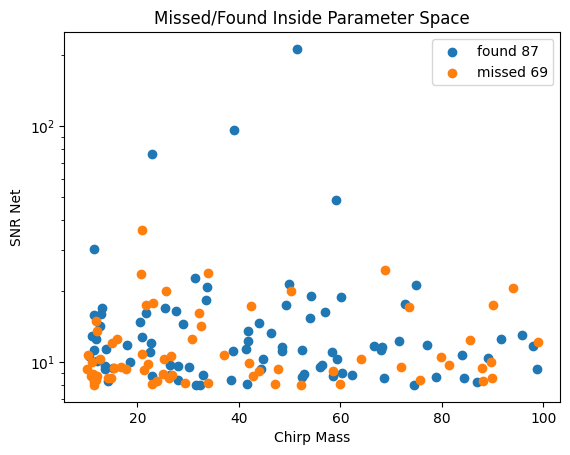

In [56]:
plt.scatter(found["chirp_mass"], found["snr_net"], label=f'found {len(found)}')
plt.scatter(missed["chirp_mass"], missed["snr_net"], label=f'missed {len(missed)}')
plt.xlabel("Chirp Mass")
plt.ylabel("SNR Net")
plt.title("Missed/Found Inside Parameter Space")
plt.yscale("log")
plt.legend()

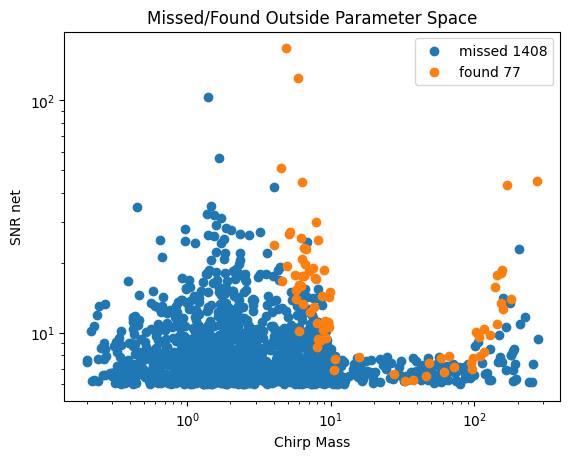

In [57]:

plt.scatter(missed_outside["chirp_mass"], missed_outside["snr_net"], label=f'missed {len(missed_outside)}')
plt.scatter(found_outside["chirp_mass"], found_outside["snr_net"], label=f'found {len(found_outside)}')
plt.title("Missed/Found Outside Parameter Space")
plt.xlabel("Chirp Mass")
plt.ylabel("SNR net")
plt.yscale("log")
plt.xscale('log')
plt.legend()

In [36]:
found.sort_values("snr_net", ascending=False).iloc[0][["time_geocenter_replay", "mass1_detector", "mass2_detector", "snr_net", "observed_snr_H", "observed_snr_L", "H1:DMT-ANALYSIS_READY:1", "L1:DMT-ANALYSIS_READY:1"]]
                                                                                            

time_geocenter_replay      1433702282.203582
mass1_detector                     60.461408
mass2_detector                     57.856021
snr_net                           212.975193
observed_snr_H                    129.836023
observed_snr_L                     155.16652
H1:DMT-ANALYSIS_READY:1                 True
L1:DMT-ANALYSIS_READY:1                 True
Name: 395, dtype: object

In [30]:
missed.columns

Index(['spin1_azimuthal_angle', 'spin1_magnitude', 'spin2z', 'fref',
       'observed_phase_maximized_snr_net', 'time_V', 'spin2_magnitude',
       'phenomxhm_mband_threshold', 'lnpdraw_spin2_azimuthal_angle',
       'right_ascension', 'time_geocenter', 'coa_phase', 'spin2y',
       'observed_phase_maximized_snr_H', 'observed_phase_maximized_snr_V',
       'snr_H', 'spin2_polar_angle', 'inclination', 'lnpdraw_polarization',
       'mass2_source', 'spin1_polar_angle', 'lnpdraw_spin1_azimuthal_angle',
       'lnpdraw_time_geocenter', 'snr_flow', 'observed_snr_V', 'time_H',
       'snr_fhigh', 'mass1_source', 'chi_eff', 'waveform_flow',
       'observed_snr_L', 'q', 'observed_snr_H', 'snr_net',
       'phenomxphm_mband_threshold', 'lnpdraw_right_ascension',
       'lnpdraw_inclination', 'lnpdraw_declination', 'approximant', 'time_L',
       'spin1z',
       'lnpdraw_mass1_source_mass2_source_spin1_magnitude_spin2_magnitude_z',
       'lnpdraw_spin2_polar_angle', 'polarization', 'declinati